In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import findspark
findspark.init() 

import pyspark
sc = pyspark.SparkContext()

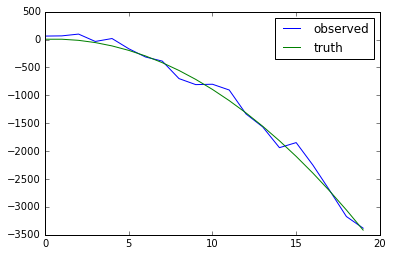

In [335]:
##### Start with linear regression #######

N = 20 #Number of observations
b = 1 #Bias/Intercept
d = 3 #Number of features/weights

#Build feature matrix that maps x to y
feature_map = np.zeros((N,d))
feature_map[:,0] = 1
feature_map[:,1] = range(N)
feature_map[:,2] = [-0.5*(q**2) for q in range(N)]

#Get true value of y
xdat = range(N)
w_true = [5, 10, 20]
y = np.dot(feature_map, w_true)

#Add noise to y
ydat = [q+np.random.normal(0,100,1)[0] for q in y]

plt.plot(xdat, ydat, label='observed')
plt.plot(xdat, y, label='truth')
plt.legend()
plt.show()


In [337]:

lambda_grid = [1e-4, 1e-3, 1e-2, 0, 10, 1e2]


In [338]:
dpoints = zip(ydat, feature_map)

#Start spark instance on points
points = sc.parallelize(dpoints)

#First use Spark to center the image - removes bias
x_mean = points.map(lambda x: x[1]).reduce(lambda x,y: (x+y) ) / float(N)
y_mean = np.mean(ydat)

x_c = points.map(lambda x: x[1] - x_mean).take(N)
y_c = [iy - y_mean for iy in ydat]

#Start spark instance on centered points
cpoints = sc.parallelize(zip(y_c, x_c))


In [339]:
#Analytical solution to problem

#Do numerator first - doesn't require regularization
numer_map = cpoints.map(lambda x:x[1] * (x[0])) 
numer_sum = numer_map.reduce(lambda x,y: x+y)

#Do denominator over lambda grid
#Get analytical solution with associated error
w_stars = []
w_error = []
for ll in lambda_grid:
    denom_map = cpoints.map(lambda x: np.dot(x[1], x[1].T) + N*ll) #Need to add regularization - lambda
    denom_sum = denom_map.reduce(lambda x,y: x+y)
    iw = numer_sum / float(denom_sum)
    err = np.linalg.norm(np.dot(x_c, iw) - y_c)

    w_stars.append(iw)
    w_error.append(err)
    
#Choose best solution
w_star = w_stars[np.where(w_error == np.min(w_error))[0][0]]


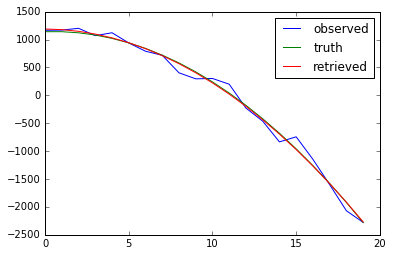

In [342]:
#Visualize Result
plt.plot(xdat, y_c, label='observed')
plt.plot(xdat, [iy - np.mean(y) for iy in y], label='truth')
plt.plot(np.dot(x_c, w_star), label='retrieved')
plt.legend()
plt.show()
